In [1]:
import datetime
import time
import sys
import glob
sys.path.append('..')
sys.path.append('../src')

# --- Dependencies
import pygmo as pg
import numpy as np
import pandas as pd
import sobol_seq
# import dovpanda

import plotly
from plotly import graph_objs as go
from plotly import tools
import plotly.express as px

# import sklearn.gaussian_process as gp
# from sklearn.model_selection import cross_val_score, cross_validate
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.linear_model import LinearRegression

from src.composite import PredictTutor, ModelsUnion
# from src.generator import SamplesGenerator
from src.ploting import plot_mo

def make_nd_pop(pro, x, y):
    nd_front = pg.fast_non_dominated_sorting(y)[0][0]
    nd_x = np.array(x)[nd_front]
    nd_y = np.array(y)[nd_front]
    t_pop = pg.population(pro)
    for i, p_vector in enumerate(nd_x):
        t_pop.push_back(x=p_vector, f=nd_y[i])
    return t_pop

In [42]:
# # Deine problem
# DIM = 2
# ID = 4
# OBJ = 2

# # udp = pg.wfg(prob_id=ID, dim_dvs=DIM, dim_obj=OBJ, dim_k=OBJ-1)  # == WFG
# # udp = pg.zdt(prob_id=ID, param=DIM) # == ZDT
# udp = pg.dtlz(prob_id=2, dim=9, fdim=2) # == DTLZ
# pro = pg.problem(udp)

# name = 'DTLZ2_*.pkl'
# folder = './data/tutorm/scale/pkl/'
# paths = [i for i in glob.glob('{}{}'.format(folder, name))]

# group = []
# for p in paths:
#     temp_df = pd.read_pickle(p)
#     idx = p.find('.', 1)+1
#     group_id = p[idx:idx+15]
#     temp_df['group_id'] = group_id
#     group.append(temp_df)

# mapr_concat = pd.concat(group)
# name = 'DTLZ2_9_{}k_x5.pkl'.format(int(len(mapr_concat)/1000))
# mapr_concat.to_pickle('./data/tutorm/scale/concat/'+name)

In [66]:
portfolio = ["['MLPRegressor']", "['ModelsUnion', 'ModelsUnion', 'ModelsUnion']", "['GaussianProcessRegressor']"]
columns = ['p_distance', 'i_fevals', 'i_time', 'portfolio', 'tutor_id', 'group_id', 'objectives', 'model name', 'params hash']

df = pd.read_pickle('./data/tutorm/scale/concat/DTLZ2_9_0k_x5.pkl')[columns]
df['model name'] = df['model name'].apply(lambda x: str(x))
df['portfolio'] = df['portfolio'].apply(lambda x: str(x))
df = df[df["params hash"]!= "1e5c"] 
df = df.loc[df['portfolio'].isin(portfolio)]
# df = df.query('portfolio=={}')
# df = df[df["params hash"]!= "7bc4"] 

df['i_fevals/obj'] = df['i_fevals']/df['objectives']
# df[df["portfolio"]== "['MLPRegressor']"]['params hash'].unique()

In [67]:
df.portfolio.unique().tolist()

["['MLPRegressor']",
 "['ModelsUnion', 'ModelsUnion', 'ModelsUnion']",
 "['GaussianProcessRegressor']"]

In [68]:
df

,p_distance,i_fevals,i_time,portfolio,tutor_id,group_id,objectives,model name,params hash,i_fevals/obj
0,0.135367,400,0.035438,['MLPRegressor'],140154352253840,140154352253840,8,sampling plan,NaN,50.0
0,0.135367,400,0.039423,['MLPRegressor'],140062295856848,140062295856848,8,sampling plan,NaN,50.0
1,0.165819,800,640.061674,['MLPRegressor'],140062295856848,140062295856848,8,mlpregressor,7bc4,100.0
2,0.247974,1200,1414.322325,['MLPRegressor'],140062295856848,140062295856848,8,mlpregressor,7bc4,150.0
3,0.288823,1600,1929.311077,['MLPRegressor'],140062295856848,140062295856848,8,mlpregressor,7bc4,200.0
...,...,...,...,...,...,...,...,...,...,...
5,0.020505,600,404.509174,"['ModelsUnion', 'ModelsUnion', 'ModelsUnion']",139873032415888,139873032415888,2,"['mlpregressor', 'gradientboostingregressor']","[1e5c, 591a]",300.0
6,0.025135,700,489.365843,"['ModelsUnion', 'ModelsUnion', 'ModelsUnion']",139873032415888,139873032415888,2,"['mlpregressor', 'mlpregressor']","[1e5c, 1e5c]",350.0
7,0.024256,800,576.733654,"['ModelsUnion', 'ModelsUnion', 'ModelsUnion']",139873032415888,139873032415888,2,"['mlpregressor', 'mlpregressor']","[1e5c, 1e5c]",400.0
8,0.023889,900,663.512677,"['ModelsUnion', 'ModelsUnion', 'ModelsUnion']",139873032415888,139873032415888,2,"['mlpregressor', 'mlpregressor']","[1e5c, 1e5c]",450.0


In [71]:
grp_df = df.groupby(['i_fevals/obj', 'portfolio', 'objectives']).mean()
grp_df.reset_index(inplace=True)

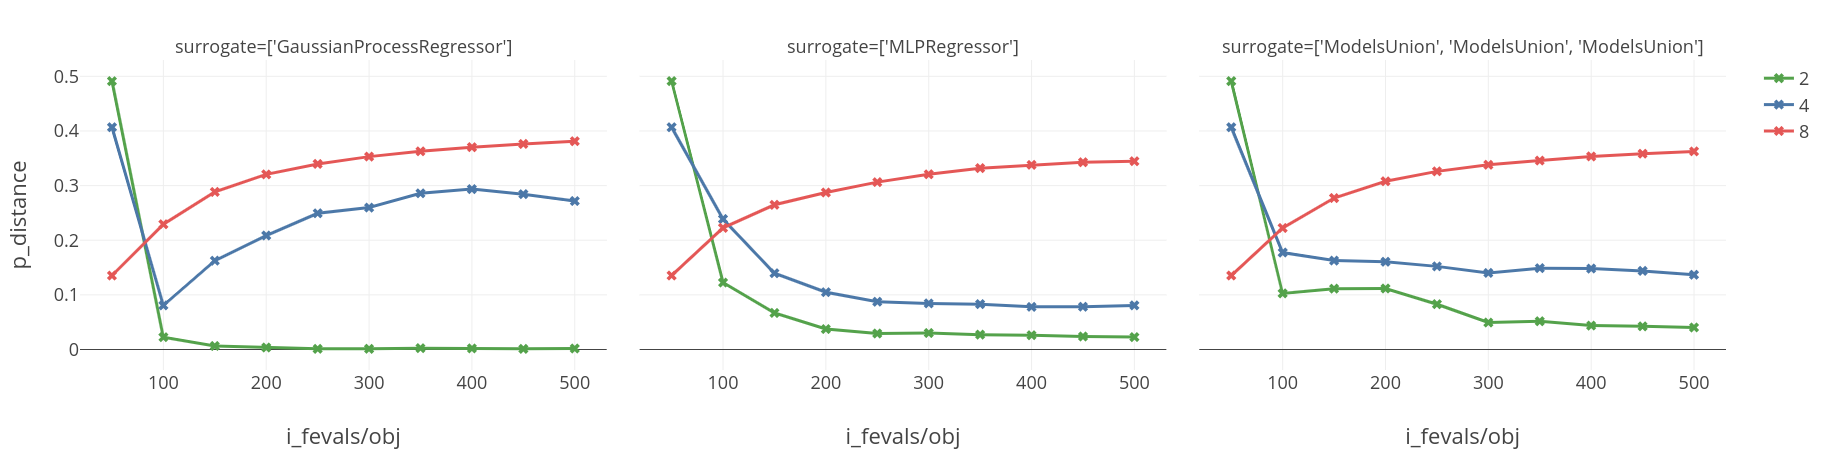

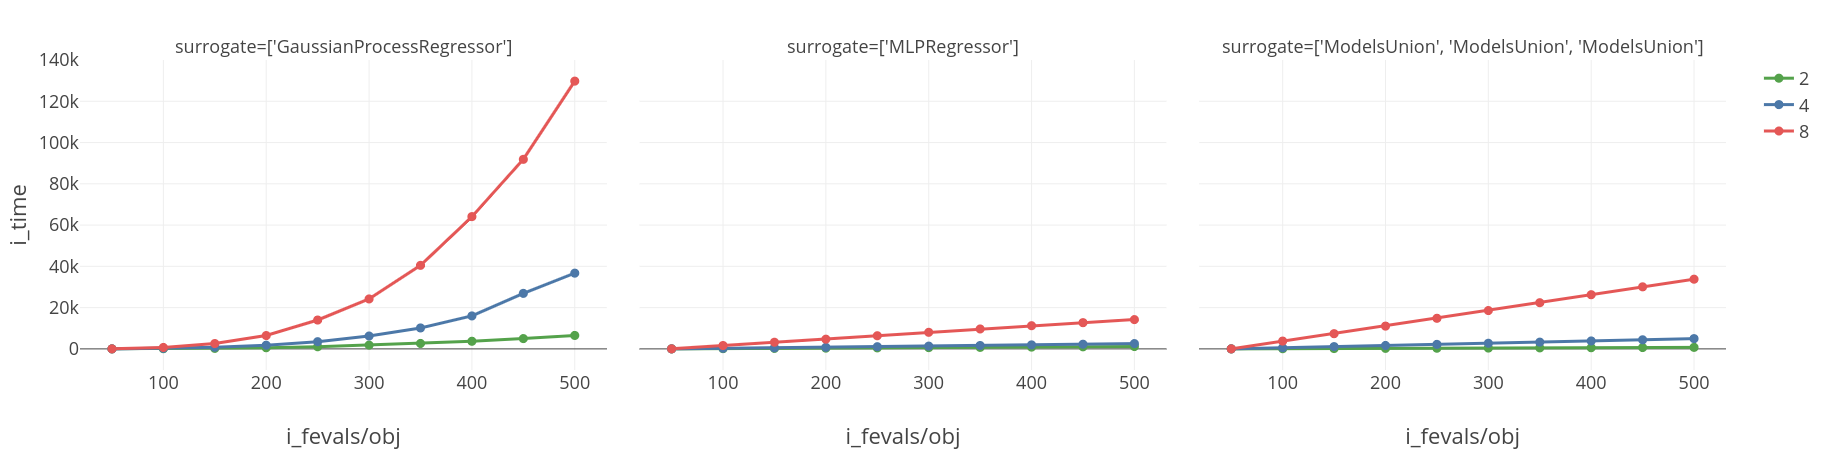

In [127]:
grp_df.rename({'portfolio': 'surrogate'}, axis=1, inplace=True)
grp_df.sort_values(['surrogate', 'i_fevals/obj'], inplace=True)
fig = px.line(grp_df, template="presentation",
                 x="i_fevals/obj",
                 y="p_distance",
                 color="objectives",
                 facet_col="surrogate",
#                  color_discrete_sequence=['rgb(150,0,90)', 'rgb(0,0,200)',  'rgb(255,234,0)', 'rgb(255,111,0)', '#fe88ec', 'rgb(151,255,0)'],
#                  color_discrete_sequence=px.colors.sequential.Rainbow, 
                 color_discrete_sequence=[ '#54A24B', '#4C78A8', '#E45756','#FF9DA6', '#B279A2', '#72B7B2'],
#                  render_mode="webgl", 
                 )
# fig.update_layout(title=None, coloraxis_showscale=False, marker=dict(symbol='x'))
for l in fig['data']:
    l.update(mode='markers+lines', marker=dict(symbol='x'))
    
fig.show()



fig2 = px.line(grp_df, template="presentation",
                  x="i_fevals/obj",
                  y="i_time",
                  color="objectives",
                  facet_col="surrogate",
#                   color_discrete_sequence=['rgb(150,0,90)', 'rgb(0,0,200)',  'rgb(255,234,0)', 'rgb(255,111,0)', '#fe88ec', 'rgb(151,255,0)'],
#                   color_continuous_scale=px.colors.sequential.Rainbow, 
                  color_discrete_sequence=[ '#54A24B', '#4C78A8', '#E45756','#FF9DA6', '#B279A2', '#72B7B2'],
#                   render_mode="webgl", 
                  )

for l in fig2['data']:
    l.update(mode='markers+lines')
fig2.show()

fig.write_image("./plots/scale_DTLZ2_dist.svg", width=1400)
fig2.write_image("./plots/scale_DTLZ2_time.svg", width=1400)

In [101]:
fig['data']

(Scatter({
     'hoverlabel': {'namelength': 0},
     'hovertemplate': ("surrogate=['GaussianProcessReg" ... '<br>objectives=%{marker.color}'),
     'legendgroup': '',
     'marker': {'color': array([2, 8, 2, 8, 8, 2, 4, 8, 2, 4, 4, 8, 4, 2, 4, 8, 2, 8, 2, 4, 2, 4, 2, 8,
                                4, 8, 4, 2, 4, 8]),
                'coloraxis': 'coloraxis',
                'symbol': 'circle'},
     'mode': 'markers',
     'name': '',
     'showlegend': False,
     'x': array([ 50., 350., 400., 100., 450., 350., 450., 500., 450., 500., 250.,  50.,
                 100., 150., 400., 300., 250., 200., 500., 300., 200., 350., 100., 150.,
                  50., 250., 150., 300., 200., 400.]),
     'xaxis': 'x',
     'y': array([0.49121094, 0.36271209, 0.00200066, 0.22924562, 0.37622655, 0.00245236,
                 0.2843282 , 0.38124488, 0.00114812, 0.27169421, 0.2493059 , 0.13536658,
                 0.08077531, 0.0064328 , 0.29354524, 0.35302865, 0.00124482, 0.32050497,
           

In [82]:
grp_df

,i_fevals/obj,surrogate,objectives,p_distance,i_fevals,i_time,tutor_id
0,50.0,['GaussianProcessRegressor'],2,0.491211,100.0,0.020022,1.399829e+14
45,300.0,['GaussianProcessRegressor'],2,0.001233,600.0,1839.504303,1.399829e+14
63,400.0,['GaussianProcessRegressor'],2,0.002001,800.0,3687.169456,1.399829e+14
38,250.0,['GaussianProcessRegressor'],8,0.339618,2000.0,13973.979274,1.399842e+14
74,450.0,['GaussianProcessRegressor'],8,0.376227,3600.0,91858.657914,1.399842e+14
...,...,...,...,...,...,...,...
26,150.0,"['ModelsUnion', 'ModelsUnion', 'ModelsUnion']",8,0.277214,1200.0,7364.754616,1.399842e+14
25,150.0,"['ModelsUnion', 'ModelsUnion', 'ModelsUnion']",4,0.162762,600.0,1092.949892,1.399842e+14
43,250.0,"['ModelsUnion', 'ModelsUnion', 'ModelsUnion']",4,0.152147,1000.0,2177.519765,1.399842e+14
35,200.0,"['ModelsUnion', 'ModelsUnion', 'ModelsUnion']",8,0.307856,1600.0,11031.648415,1.399842e+14


In [6]:
# Deine problem
DIM = 3
ID = 2
OBJ = 2

udp = pg.wfg(prob_id=ID, dim_dvs=DIM, dim_obj=OBJ, dim_k=OBJ-1)  # == WFG
# udp = pg.zdt(prob_id=ID, param=DIM) # == ZDT
# udp = pg.dtlz(prob_id=4, dim=3, fdim=2) # == DTLZ
pro = pg.problem(udp)
